In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import numpy as np

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [2]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field
from track_linearization import get_linearized_position
from replay_trajectory_classification import make_track_graph
import numpy as np


def generate_position(traversal_path, track_graph, step_size=0.020, n_traversals=10):
    points = []
    for _ in range(n_traversals):
        for node1, node2 in traversal_path:
            x1, y1 = track_graph.nodes[node1]['pos']
            x2, y2 = track_graph.nodes[node2]['pos']
            dx, dy = x2 - x1, y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            n_points = int(dist // step_size)
            w = np.linspace(0, 1, n_points)
            points.append((x1 + dx * w, y1 + dy * w))

    return np.concatenate(points, axis=1).T

def get_unique_place_field_centers(place_field_centers):
    return np.unique((place_field_centers * 10_000).astype(int), axis=0) / 10_000

def make_two_environment_data():
    node_positions1 = [(40, 80), # 0
                       (40, 0),  # 1
                       (0, 0),   # 2
                       (0, 80),  # 3
                       (80, 0),  # 4
                       (80, 80), # 5
                       ]

    node_positions2 = [(80, 40),
                       (0, 40),
                       (0, 80),
                       (80, 80),
                       (0, 0),
                       (80, 0),
                       ]
    edges = [(0, 1),
             (1, 2),
             (2, 3),
             (1, 4),
             (4, 5)
            ]

    track_graph1 = make_track_graph(node_positions1, edges)
    track_graph2 = make_track_graph(node_positions2, edges)
    
    traversal_path = [(0, 1), (1, 2), (2, 3), (3, 2), (2, 1), (1, 0), (0, 1), (1, 4), (4, 5), (5, 4), (4, 1), (1, 0)]
    position1 = generate_position(traversal_path, track_graph1)
    position2 = generate_position(traversal_path, track_graph2)
    
    edge_order = ((0, 1),
                  (1, 2),
                  (2, 3),
                  (1, 4),
                  (4, 5)
                 )
    edge_spacing = (30, 0, 30, 0)
    position_df1 = get_linearized_position(position1,
                                           track_graph1,
                                           edge_order=edge_order,
                                           edge_spacing=edge_spacing,
                                           use_HMM=False)
    position_df2 = get_linearized_position(position2,
                                          track_graph2,
                                          edge_order=edge_order,
                                          edge_spacing=edge_spacing,
                                          use_HMM=False)
    
    sampling_frequency = 1000

    place_field_centers1 = generate_position(traversal_path, track_graph1, step_size=10, n_traversals=1)
    place_field_centers1 = get_unique_place_field_centers(place_field_centers1)
    
    spikes1 = np.stack([simulate_neuron_with_place_field(center, position1,
                                                        sampling_frequency=sampling_frequency,
                                                        variance=6.0**2)
                       for center in place_field_centers1], axis=1)
    
    place_field_centers2 = generate_position(traversal_path, track_graph2, step_size=10, n_traversals=1)
    place_field_centers2 = get_unique_place_field_centers(place_field_centers2)
    
    spikes2 = np.stack([simulate_neuron_with_place_field(center, position2,
                                                    sampling_frequency=sampling_frequency,
                                                    variance=6.0**2)
                   for center in place_field_centers2], axis=1)
    
    return (spikes1, spikes2,
            position_df1, position_df2,
            track_graph1, track_graph2, 
            place_field_centers1, place_field_centers2,
            position1, position2,
            edge_order, edge_spacing
           )

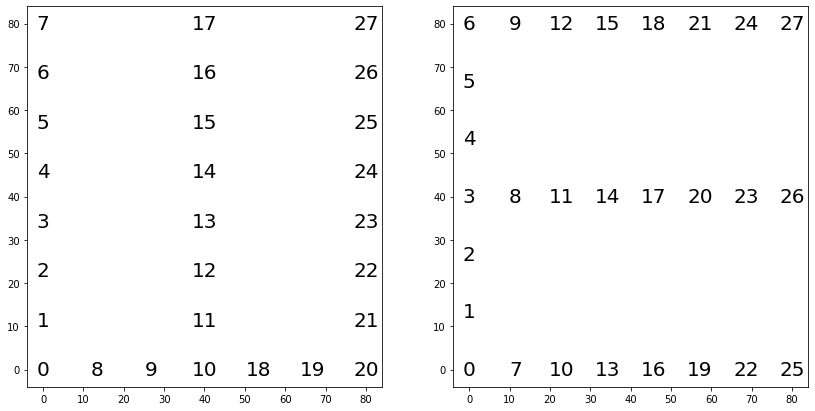

In [3]:
import matplotlib.pyplot as plt

(spikes1, spikes2,
 position_df1, position_df2,
 track_graph1, track_graph2, 
 place_field_centers1, place_field_centers2,
 position1, position2,
 edge_order, edge_spacing
) = make_two_environment_data()

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)

In [4]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:63228,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:63234,Total threads: 1
Dashboard: http://127.0.0.1:63237/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:63231,


In [5]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform

environments = (
    Environment('wtrack1', track_graph=track_graph1, edge_order=edge_order, edge_spacing=edge_spacing),
    Environment('wtrack2', track_graph=track_graph2, edge_order=edge_order, edge_spacing=edge_spacing))

continuous_transition_types = [[RandomWalk('wtrack1'),         Uniform('wtrack1', 'wtrack2')],
                               [Uniform('wtrack2', 'wtrack1'), RandomWalk('wtrack2')]]

classifier = SortedSpikesClassifier(
    environments=environments,
    continuous_transition_types=continuous_transition_types,
)
classifier

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=6.0, movement_mean=0.0)]],
                       discrete_transiti...
                                     Environment(environment_name='wtrack2', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x131277520>, edge_order=((0, 1), (1, 2), (2, 3), (1, 4), (4, 5)), edge_spacing=(30, 0, 30, 0), is_track_interior=None, position_range=None, infer_track_interior=True)),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
           

In [6]:
position = np.concatenate((position_df1.linear_position.values,
                           position_df2.linear_position.values))
spikes = np.concatenate((spikes1, spikes2))
environment_labels = np.concatenate((['wtrack1'] * spikes1.shape[0],
                                     ['wtrack2'] * spikes2.shape[0],
                                    ))
environment_names_to_state = ['wtrack1', 'wtrack2']
classifier.fit(
    position=position,
    spikes=spikes,
    environment_labels=environment_labels,
    environment_names_to_state=environment_names_to_state,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=6.0, movement_mean=0.0)]],
                       discrete_transiti...
                                     Environment(environment_name='wtrack2', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x131277520>, edge_order=((0, 1), (1, 2), (2, 3), (1, 4), (4, 5)), edge_spacing=(30, 0, 30, 0), is_track_interior=None, position_range=None, infer_track_interior=True)),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
           

In [7]:
classifier.discrete_state_transition_

array([[0.98, 0.02],
       [0.02, 0.98]])

In [8]:
classifier.continuous_state_transition_

[[array([[0.49140289, 0.35210556, 0.1295324 , ..., 0.        , 0.        ,
          0.        ],
         [0.26041277, 0.3634353 , 0.26041277, ..., 0.        , 0.        ,
          0.        ],
         [0.08742513, 0.23764615, 0.33166192, ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.33166192, 0.23764615,
          0.08742513],
         [0.        , 0.        , 0.        , ..., 0.26041277, 0.3634353 ,
          0.26041277],
         [0.        , 0.        , 0.        , ..., 0.1295324 , 0.35210556,
          0.49140289]]),
  array([[0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         [0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         [0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         ...,
         [0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         [0.00625, 0.00625, 0.00625, ..., 0.00625, 0.00625, 0.00625],
         [0.00625, 0.00625, 0.00

In [9]:
classifier.place_fields_

{('wtrack2',
  0): <xarray.DataArray (position: 162, neuron: 28)>
 array([[0.00021839, 0.00021622, 0.00022339, ..., 0.00014101, 0.01082668,
         0.00014303],
        [0.00020772, 0.00020578, 0.00021174, ..., 0.00013758, 0.0099619 ,
         0.00013908],
        [0.00019849, 0.00019675, 0.0002017 , ..., 0.00013454, 0.0086835 ,
         0.0001356 ],
        ...,
        [0.00022061, 0.00021831, 0.00022576, ..., 0.00393429, 0.00019261,
         0.00014401],
        [0.00022677, 0.00022436, 0.00023255, ..., 0.00409086, 0.00019923,
         0.00014613],
        [0.00023376, 0.00023122, 0.00024026, ..., 0.00399434, 0.0002068 ,
         0.00014851]])
 Coordinates:
   * position  (position) float64 1.0 3.0 5.0 7.0 9.0 ... 373.0 375.0 377.0 379.0
 Dimensions without coordinates: neuron,
 ('wtrack1',
  0): <xarray.DataArray (position: 162, neuron: 28)>
 array([[0.00021076, 0.00022618, 0.00021701, ..., 0.00021795, 0.00020273,
         0.00015514],
        [0.00020075, 0.00021484, 0.00020649, 

In [10]:
test_spikes = spikes[:10, :].copy()

In [11]:
from dataclasses import dataclass


@dataclass(order=True)
class ObservationModel:
    state_name: str = None
    environment_name: str = ''
    encoding_group: str = None
        
        
[ObservationModel(environment_name='wtrack1'),
 ObservationModel(environment_name='wtrack2')
]

blah = [ObservationModel(environment_name='wtrack1', encoding_group='Inbound'),
        ObservationModel(environment_name='wtrack1', encoding_group='Inbound'),
        ObservationModel(environment_name='wtrack1', encoding_group='Outbound'),
        ObservationModel(environment_name='wtrack1', encoding_group='Outbound'),
        ]

np.unique(blah)

array([ObservationModel(state_name=None, environment_name='wtrack1', encoding_group='Inbound'),
       ObservationModel(state_name=None, environment_name='wtrack1', encoding_group='Outbound')],
      dtype=object)

In [12]:
from replay_trajectory_classification.spiking_likelihood import estimate_spiking_likelihood
from replay_trajectory_classification.core import scaled_likelihood

n_time = test_spikes.shape[0]
n_states = classifier.discrete_state_transition_.shape[0]
max_pos_bins = np.max([env.place_bin_centers_.shape[0]
                       for env in classifier.environments])

results = {}

# initial conditions
initial_conditions = np.zeros((n_states, max_pos_bins, 1),
                               dtype=np.float64)
for state_ind, ic in enumerate(classifier.initial_conditions_):
    initial_conditions[state_ind, :ic.shape[0]] = ic[..., np.newaxis]

# likelihood
states = tuple(zip(classifier.environment_names_to_state_,
                   classifier.encoding_group_to_state_))

likelihood = {}
for (environment_name, encoding_group), place_fields in classifier.place_fields_.items():
    env_ind = classifier.environments.index(environment_name)
    is_track_interior = classifier.environments[env_ind].is_track_interior_
    likelihood[(environment_name, encoding_group)] = estimate_spiking_likelihood(
        test_spikes,
        place_fields.values,
        is_track_interior)

results['likelihood'] = np.full(
    (n_time, n_states, max_pos_bins, 1), np.nan)
for state_ind, state in enumerate(states):
    n_bins = likelihood[state].shape[1]
    results['likelihood'][:, state_ind,
                          :n_bins] = likelihood[state][..., np.newaxis]
results['likelihood'] = scaled_likelihood(
    results['likelihood'], axis=(1, 2))
results['likelihood'][np.isnan(results['likelihood'])] = 0.0

# state transition
continuous_state_transition = np.zeros(
    (n_states, n_states, max_pos_bins, max_pos_bins))

for row_ind, row in enumerate(classifier.continuous_state_transition_):
    for column_ind, st in enumerate(row):
        continuous_state_transition[
            row_ind, column_ind, :st.shape[0], :st.shape[1]] = st

In [ ]:
from replay_trajectory_classification.core import _causal_classify

results['causal_posterior'] = _causal_classify(
    initial_conditions,
    continuous_state_transition,
    classifier.discrete_state_transition_,
    results['likelihood'])

In [ ]:
results, time, state_names = classifier.predict(test_spikes)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


In [ ]:
results['causal_posterior'].shape

In [ ]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform

environments2 = (
    Environment('wtrack1', track_graph=track_graph1, edge_order=edge_order, edge_spacing=edge_spacing))

continuous_transition_types2 = [[RandomWalk('wtrack1'), Uniform('wtrack1')],
                                [Uniform('wtrack1'),    Uniform('wtrack1')]]

classifier2 = SortedSpikesClassifier(
    environments=environments2,
    continuous_transition_types=continuous_transition_types2,
)
classifier2.fit(
    position=position_df1.linear_position.values,
    spikes=spikes1,
)

In [ ]:
results2 = classifier2.predict(test_spikes)
results2

In [ ]:
results2.acausal_posterior.sum('state').plot(x='time', y='position')

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)